In [1]:
! pip install tensorflow

^C


Defaulting to user installation because normal site-packages is not writeable
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
  Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
   ---------------------------------------- 0.0/332.0 MB ? eta -:--:--
   ---------------------------------------- 1.0/332.0 MB 7.6 MB/s eta 0:00:44
   ---------------------------------------- 3.1/332.0 MB 8.8 MB/s eta 0:00:38
    --------------------------------------- 5.0/332.0 MB 8.5 MB/s eta 0:00:39
    --------------------------------------- 6.3/332.0 MB 7.9 MB/s eta 0:00:42
    --------------------------------------- 7.3/3


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array

df = pd.read_csv("english.csv")   # contains columns: image_path, label

# Image preprocessing
X, y = [], []
for _, row in df.iterrows():
    img = load_img(row['image'], color_mode='grayscale', target_size=(28,28))
    img_array = img_to_array(img).flatten() / 255.0   # flatten for PLA
    X.append(img_array)
    y.append(row['label'])

X = np.array(X)
y = np.array(y)


X_train, X_test, y_train_str, y_test_str = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [3]:
import numpy as np

# A simple Perceptron implementation for binary classification
class Perceptron:
    def __init__(self, learning_rate=0.01, n_iters=100):
        self.lr = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        # Initialize weights and bias
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        # The target labels for a binary perceptron must be +1 and -1
        y_ = np.where(y > 0, 1, -1)

        # Training loop
        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                # Check if the prediction is correct
                condition = y_[idx] * (np.dot(x_i, self.weights) + self.bias)
                if condition <= 0:
                    # Update weights and bias if incorrect
                    self.weights += self.lr * y_[idx] * x_i
                    self.bias += self.lr * y_[idx]

    def decision_function(self, X):
        # This is the raw score we will use for OvR
        return np.dot(X, self.weights) + self.bias

# --- One-vs-Rest (OvR) Implementation ---

# Find all unique character labels in the training data
unique_labels = np.unique(y_train_str)

# A dictionary to store one trained perceptron for each label
ovr_classifiers = {}

print("Training One-vs-Rest Perceptrons...")
for label in unique_labels:
    # Create a binary target array: 1 for the current label, -1 for the rest
    y_train_binary = np.where(y_train_str == label, 1, -1)
    
    # Create and train a new Perceptron for this label
    p = Perceptron(learning_rate=0.01, n_iters=10) # Using fewer iterations for speed
    p.fit(X_train, y_train_binary)
    
    # Store the trained classifier
    ovr_classifiers[label] = p
    print(f"  -> Trained classifier for '{label}'")

# --- Making Predictions on the Test Set ---

# Get decision scores from each classifier for each test sample
scores = np.zeros((X_test.shape[0], len(unique_labels)))
label_to_idx = {label: i for i, label in enumerate(unique_labels)}

for label, p in ovr_classifiers.items():
    col_idx = label_to_idx[label]
    scores[:, col_idx] = p.decision_function(X_test)

# Find the label corresponding to the highest score for each sample
predicted_label_indices = np.argmax(scores, axis=1)
y_pred = [unique_labels[i] for i in predicted_label_indices]

# --- Calculate Accuracy ---
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test_str, y_pred)
print(f"\nOverall Accuracy of One-vs-Rest PLA: {accuracy * 100:.2f}%")

Training One-vs-Rest Perceptrons...
  -> Trained classifier for '0'
  -> Trained classifier for '1'
  -> Trained classifier for '2'
  -> Trained classifier for '3'
  -> Trained classifier for '4'
  -> Trained classifier for '5'
  -> Trained classifier for '6'
  -> Trained classifier for '7'
  -> Trained classifier for '8'
  -> Trained classifier for '9'
  -> Trained classifier for 'A'
  -> Trained classifier for 'B'
  -> Trained classifier for 'C'
  -> Trained classifier for 'D'
  -> Trained classifier for 'E'
  -> Trained classifier for 'F'
  -> Trained classifier for 'G'
  -> Trained classifier for 'H'
  -> Trained classifier for 'I'
  -> Trained classifier for 'J'
  -> Trained classifier for 'K'
  -> Trained classifier for 'L'
  -> Trained classifier for 'M'
  -> Trained classifier for 'N'
  -> Trained classifier for 'O'
  -> Trained classifier for 'P'
  -> Trained classifier for 'Q'
  -> Trained classifier for 'R'
  -> Trained classifier for 'S'
  -> Trained classifier for 'T'
  ->

In [ ]:
! pip install seaborn



Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: C:\Python313\python.exe -m pip install --upgrade pip


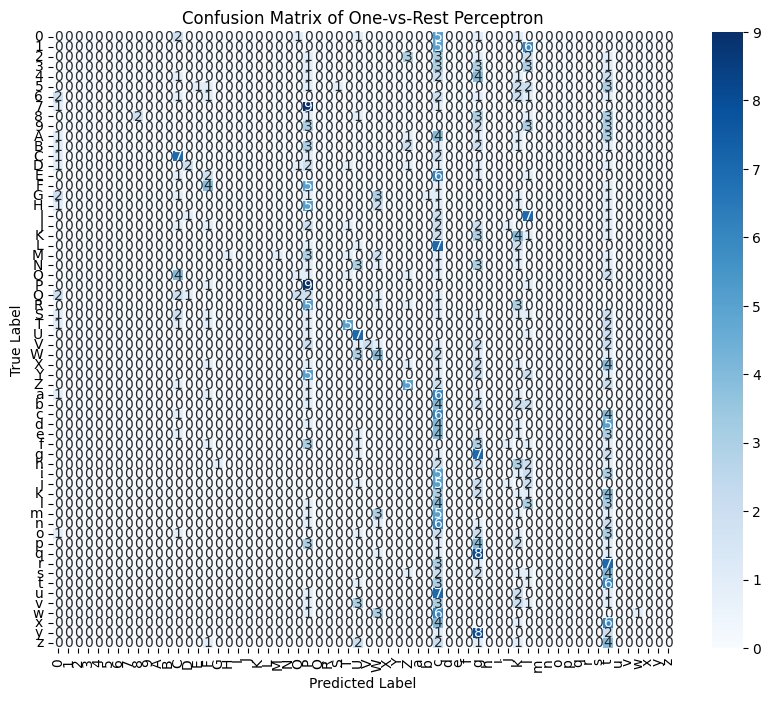

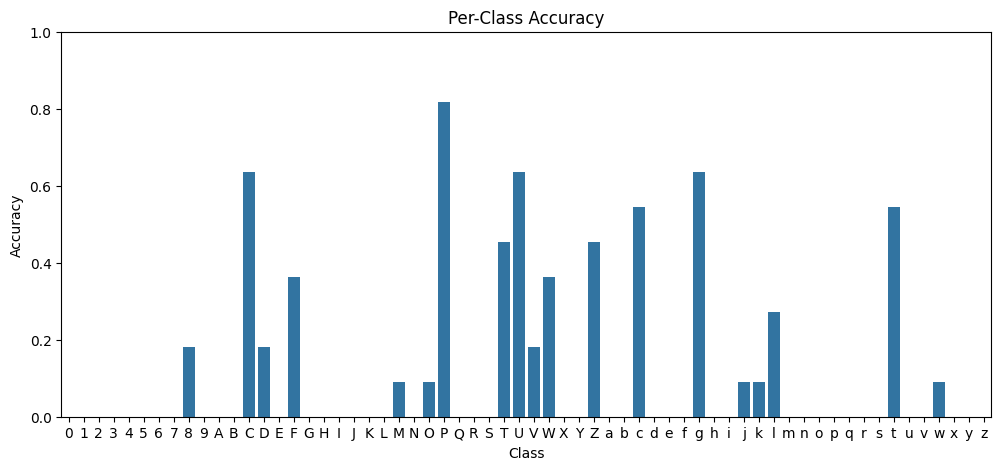

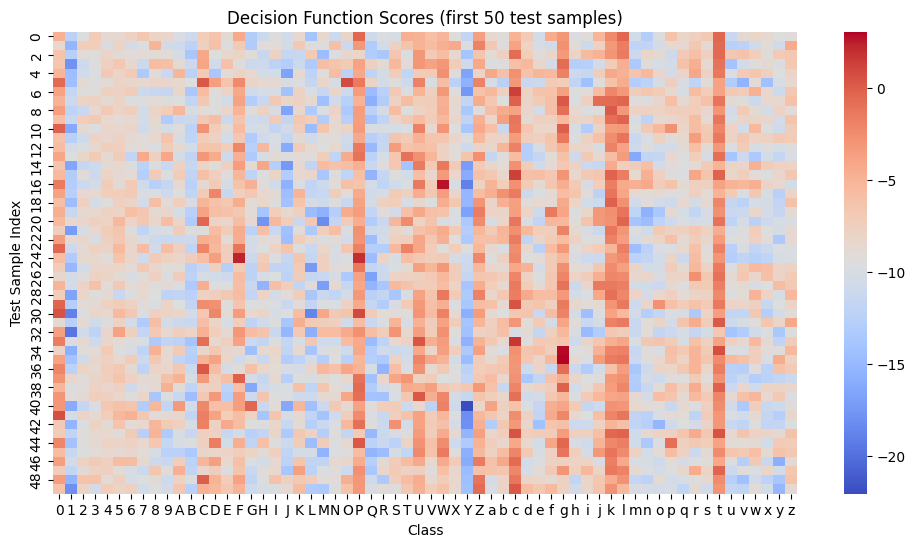

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# --- 1. Confusion Matrix ---
cm = confusion_matrix(y_test_str, y_pred, labels=unique_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Confusion Matrix of One-vs-Rest Perceptron')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# --- 2. Accuracy per class ---
# Calculate accuracy per class
class_accuracy = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(12, 5))
sns.barplot(x=unique_labels, y=class_accuracy)
plt.title('Per-Class Accuracy')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

# --- 3. Optional: Decision Scores Heatmap for first 50 samples ---
plt.figure(figsize=(12, 6))
sns.heatmap(scores[:50], cmap='coolwarm', annot=False, xticklabels=unique_labels)
plt.title('Decision Function Scores (first 50 test samples)')
plt.xlabel('Class')
plt.ylabel('Test Sample Index')
plt.show()


In [ ]:
! pip install torch torchvision torchaudio

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# --- Load and preprocess dataset ---
print("Loading and preprocessing data from english.csv...")
df = pd.read_csv("english.csv")

X_list, y_list = [], []
for _, row in df.iterrows():
    try:
        img = Image.open(row['image']).convert('L').resize((28, 28))
        img_array = np.array(img).flatten() / 255.0
        X_list.append(img_array)
        y_list.append(row['label'])
    except FileNotFoundError:
        print(f"Warning: File not found at {row['image']}. Skipping.")

X = np.array(X_list, dtype=np.float32)
y_str = np.array(y_list)
print("Data loading complete.")

# Encode labels
encoder = LabelEncoder()
y = encoder.fit_transform(y_str)
num_classes = len(encoder.classes_)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Standardization
mean = np.mean(X_train)
std = np.std(X_train)
X_train = (X_train - mean) / (std + 1e-7)
X_test = (X_test - mean) / (std + 1e-7)
print("Data standardization complete.")

# Convert to tensors
X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# --- Define MLP ---
class MLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.layers(x)

# --- Training ---
input_size = X_train.shape[1]
model = MLP(input_size=input_size, num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("\nStarting PyTorch MLP training...")
n_epochs = 60
for epoch in range(n_epochs):
    model.train()
    for images, labels in train_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}')

# --- Evaluation ---
print("\nEvaluating model...")
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy on test data: {accuracy * 100:.2f}%')


Loading and preprocessing data from english.csv...
Data loading complete.
Data standardization complete.

Starting PyTorch MLP training...
Epoch [1/60], Loss: 3.5518
Epoch [2/60], Loss: 3.1232
Epoch [3/60], Loss: 2.7920
Epoch [4/60], Loss: 2.1797
Epoch [5/60], Loss: 2.3738
Epoch [6/60], Loss: 1.8433
Epoch [7/60], Loss: 1.4935
Epoch [8/60], Loss: 1.2241
Epoch [9/60], Loss: 1.2665
Epoch [10/60], Loss: 0.9280
Epoch [11/60], Loss: 1.2883
Epoch [12/60], Loss: 1.0341
Epoch [13/60], Loss: 0.8313
Epoch [14/60], Loss: 0.7838
Epoch [15/60], Loss: 0.9003
Epoch [16/60], Loss: 0.6846
Epoch [17/60], Loss: 0.5731
Epoch [18/60], Loss: 0.6210
Epoch [19/60], Loss: 0.5364
Epoch [20/60], Loss: 0.4452
Epoch [21/60], Loss: 0.5565
Epoch [22/60], Loss: 0.3616
Epoch [23/60], Loss: 0.4380
Epoch [24/60], Loss: 0.4441
Epoch [25/60], Loss: 0.6140
Epoch [26/60], Loss: 0.8154
Epoch [27/60], Loss: 0.4130
Epoch [28/60], Loss: 0.4799
Epoch [29/60], Loss: 0.3955
Epoch [30/60], Loss: 0.4716
Epoch [31/60], Loss: 0.4910
Ep

In [2]:
pip install tensorflow-cpu


^C
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
   ---------------------------------------- 0.0/332.0 MB ? eta -:--:--
   ---------------------------------------- 1.0/332.0 MB 7.8 MB/s eta 0:00:43
   ---------------------------------------- 1.8/332.0 MB 4.8 MB/s eta 0:01:10
   ---------------------------------------- 2.4/332.0 MB 4.4 MB/s eta 0:01:15
   ---------------------------------------- 2.9/332.0 MB 3.3 MB/s eta 0:01:40
   ---------------------------------------- 3.4/332.0 MB 3.2 MB/s eta 0:01:43
   ---------------------------------------- 3.9/332.0 MB 3.2 MB/s eta 0:01:44
    --------------------------------------- 4.5/332.0 MB 3.1 MB/s eta 0:01:46
    --------------------------------------- 5.2/332.0 MB 3.2 MB/s eta 0:01:44
    --------------------------------------- 5.8/332.0 MB 3.1 MB/s eta 0:01:45
    -----------------

In [ ]:


# Cell 1: Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm import tqdm

import torch
from torchvision import datasets, transforms

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelBinarizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, callbacks

# Fix random seeds for reproducibility (somewhat)
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
torch.manual_seed(SEED)

# Cell 2: Load EMNIST 'byclass' (62 classes)
# NOTE: torchvision.datasets.EMNIST requires torchvision >= 0.4 and will download ~200MB+
transform = transforms.Compose([
    transforms.ToTensor()
])

print("Downloading EMNIST (byclass). This may take a few minutes...")
emnist_train = datasets.EMNIST(root='./data', split='byclass', train=True, download=True, transform=transform)
emnist_test  = datasets.EMNIST(root='./data', split='byclass', train=False, download=True, transform=transform)

# Convert to numpy arrays
def dataset_to_numpy(ds):
    X = []
    y = []
    for img, label in ds:
        # EMNIST images often need transposition/rotation; torchvision returns correctly oriented images for transforms.ToTensor()
        arr = img.numpy().squeeze()  # (28,28)
        X.append(arr)
        y.append(int(label))
    X = np.stack(X).astype(np.float32)  # shape (N, 28, 28)
    y = np.array(y, dtype=np.int32)
    return X, y

X_train_img, y_train = dataset_to_numpy(emnist_train)
X_test_img,  y_test  = dataset_to_numpy(emnist_test)

print("Train images:", X_train_img.shape, "Test images:", X_test_img.shape)
print("Unique classes:", np.unique(y_train).shape[0])

# Cell 3: Preprocess: resize if needed, flatten, normalize, optionally subsample for speed
# We'll normalize to [0,1], flatten (28*28 = 784)
X_train = X_train_img.reshape((-1, 28*28)) / 255.0
X_test  = X_test_img.reshape((-1, 28*28))  / 255.0

# Optionally subsample for quicker experiments (uncomment to use)
# SUBSAMPLE = 20000
# X_train, y_train = X_train[:SUBSAMPLE], y_train[:SUBSAMPLE]

# Shuffle training set
X_train, y_train = shuffle(X_train, y_train, random_state=SEED)

# One-hot for MLP & ROC calculations
lb = LabelBinarizer()
lb.fit(np.arange(62))
y_train_oh = lb.transform(y_train)
y_test_oh  = lb.transform(y_test)

# Print basic stats
print("Shapes: X_train", X_train.shape, "y_train", y_train.shape)
print("Classes:", np.unique(y_train).shape[0])

# Cell 4: PLA implementation (one-vs-rest multiclass)
class PerceptronPLA_OVR:
    def __init__(self, n_classes, n_features, learning_rate=1e-2, n_epochs=10, shuffle=True):
        self.n_classes = n_classes
        self.n_features = n_features
        self.lr = learning_rate
        self.n_epochs = n_epochs
        self.shuffle = shuffle
        # weight matrix: one row per class, shape (n_classes, n_features + 1) including bias
        self.W = np.zeros((n_classes, n_features + 1), dtype=np.float32)
    
    def _add_bias(self, X):
        return np.concatenate([np.ones((X.shape[0],1), dtype=X.dtype), X], axis=1)
    
    def fit(self, X, y, verbose=False):
        Xb = self._add_bias(X)  # shape N x (D+1)
        for epoch in range(self.n_epochs):
            if self.shuffle:
                idx = np.random.permutation(Xb.shape[0])
                Xb = Xb[idx]
                y  = y[idx]
            updates = 0
            for i in range(Xb.shape[0]):
                xi = Xb[i]
                yi = y[i]
                # For OVR: compute scores for each class
                scores = self.W.dot(xi)  # shape (n_classes,)
                pred_class = np.argmax(scores)
                if pred_class != yi:
                    # update true class: W_y = W_y + lr * x
                    # update predicted class: W_pred = W_pred - lr * x
                    self.W[yi]   += self.lr * xi
                    self.W[pred_class] -= self.lr * xi
                    updates += 1
            if verbose:
                print(f"Epoch {epoch+1}/{self.n_epochs} - updates: {updates}")
            if updates == 0:
                break
    
    def predict(self, X):
        Xb = self._add_bias(X)
        scores = Xb.dot(self.W.T)  # N x n_classes
        return np.argmax(scores, axis=1)
    
    def decision_function(self, X):
        # returns raw scores N x n_classes
        Xb = self._add_bias(X)
        return Xb.dot(self.W.T)

# Train PLA
pla = PerceptronPLA_OVR(n_classes=62, n_features=28*28, learning_rate=0.0005, n_epochs=25, shuffle=True)
t0 = time.time()
pla.fit(X_train, y_train, verbose=True)
t1 = time.time()
print("PLA training time (s):", round(t1-t0,3))

# Evaluate PLA
y_pred_pla = pla.predict(X_test)
acc_pla = accuracy_score(y_test, y_pred_pla)
prec_pla = precision_score(y_test, y_pred_pla, average='macro', zero_division=0)
rec_pla = recall_score(y_test, y_pred_pla, average='macro', zero_division=0)
f1_pla  = f1_score(y_test, y_pred_pla, average='macro', zero_division=0)
print(f"PLA Accuracy: {acc_pla:.4f}, Precision (macro): {prec_pla:.4f}, Recall (macro): {rec_pla:.4f}, F1 (macro): {f1_pla:.4f}")

# For ROC: get score matrix and compute micro/macro ROC AUC
scores_pla = pla.decision_function(X_test)
try:
    auc_micro_pla = roc_auc_score(y_test_oh, scores_pla, average='micro', multi_class='ovr')
    auc_macro_pla = roc_auc_score(y_test_oh, scores_pla, average='macro', multi_class='ovr')
except Exception as e:
    auc_micro_pla = None
    auc_macro_pla = None

print("PLA AUC (micro, macro):", auc_micro_pla, auc_macro_pla)

# Cell 5: MLP implementation (Keras) with simple manual grid search
def build_mlp(input_dim, hidden_layers=[512,256], activation='relu', dropout=0.2, n_classes=62, lr=1e-3):
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=(input_dim,)))
    for units in hidden_layers:
        model.add(layers.Dense(units, activation=activation))
        if dropout and dropout>0:
            model.add(layers.Dropout(dropout))
    model.add(layers.Dense(n_classes, activation='softmax'))
    opt = optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Grid to try (small grid — extend as needed)
mlp_grid = [
    {"hidden": [512,256], "activation":"relu", "lr":1e-3, "batch":128, "dropout":0.2, "epochs":25},
    {"hidden": [256,128], "activation":"relu", "lr":1e-3, "batch":128, "dropout":0.2, "epochs":25},
    {"hidden": [512,256], "activation":"tanh", "lr":1e-3, "batch":128, "dropout":0.2, "epochs":25},
    {"hidden": [512,256], "activation":"relu", "lr":1e-4, "batch":256, "dropout":0.3, "epochs":30},
    {"hidden": [1024,512,256], "activation":"relu", "lr":1e-3, "batch":128, "dropout":0.3, "epochs":20}
]

mlp_results = []
best_val_acc = -1
best_model = None
best_cfg = None

# Use small validation split from training set for quick comparisons
for cfg in mlp_grid:
    print("Training MLP with config:", cfg)
    model = build_mlp(input_dim=28*28, hidden_layers=cfg['hidden'], activation=cfg['activation'], dropout=cfg['dropout'], n_classes=62, lr=cfg['lr'])
    es = callbacks.EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True, verbose=0)
    hist = model.fit(X_train, tf.keras.utils.to_categorical(y_train), validation_split=0.1, epochs=cfg['epochs'], batch_size=cfg['batch'], callbacks=[es], verbose=1)
    val_acc = max(hist.history['val_accuracy'])
    train_time = hist.history.get('val_loss')  # just to keep variable name; not used
    print(" -> best val acc:", val_acc)
    mlp_results.append((cfg, val_acc, hist))
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model = model
        best_cfg = cfg

print("Best MLP config:", best_cfg, "Val acc:", best_val_acc)

# Evaluate best model on test set
y_prob_mlp = best_model.predict(X_test, batch_size=best_cfg['batch'])
y_pred_mlp = np.argmax(y_prob_mlp, axis=1)

acc_mlp = accuracy_score(y_test, y_pred_mlp)
prec_mlp = precision_score(y_test, y_pred_mlp, average='macro', zero_division=0)
rec_mlp = recall_score(y_test, y_pred_mlp, average='macro', zero_division=0)
f1_mlp  = f1_score(y_test, y_pred_mlp, average='macro', zero_division=0)
auc_micro_mlp = roc_auc_score(y_test_oh, y_prob_mlp, average='micro', multi_class='ovr')
auc_macro_mlp = roc_auc_score(y_test_oh, y_prob_mlp, average='macro', multi_class='ovr')

print(f"MLP Test Accuracy: {acc_mlp:.4f}, Precision (macro): {prec_mlp:.4f}, Recall (macro): {rec_mlp:.4f}, F1 (macro): {f1_mlp:.4f}")
print("MLP AUC (micro, macro):", auc_micro_mlp, auc_macro_mlp)

# Cell 6: Confusion matrices and ROC curves plotting
import itertools
from sklearn.metrics import ConfusionMatrixDisplay

# Confusion Matrices (PLA & MLP)
cm_pla = confusion_matrix(y_test, y_pred_pla)
cm_mlp = confusion_matrix(y_test, y_pred_mlp)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.heatmap(cm_pla, cmap='Blues', cbar=False)
plt.title('PLA Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('True')

plt.subplot(1,2,2)
sns.heatmap(cm_mlp, cmap='Blues', cbar=False)
plt.title('MLP Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.tight_layout()
plt.show()

# ROC Curves (plot micro-average)
plt.figure(figsize=(8,6))
# PLA ROC (use scores_pla)
if auc_micro_pla is not None:
    # micro ROC
    fpr_pla, tpr_pla, _ = roc_curve(y_test_oh.ravel(), scores_pla.ravel())
    plt.plot(fpr_pla, tpr_pla, label=f"PLA (AUC micro ? -- computed above)")

# MLP ROC
fpr_mlp, tpr_mlp, _ = roc_curve(y_test_oh.ravel(), y_prob_mlp.ravel())
plt.plot(fpr_mlp, tpr_mlp, label=f"MLP (AUC micro={auc_micro_mlp:.3f}, macro={auc_macro_mlp:.3f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (micro-average)')
plt.legend()
plt.show()

# Cell 7: Training error vs epochs (for best MLP) - use hist from best cfg
# Find hist object for best_cfg from mlp_results
best_hist = None
for (cfg, val_acc, hist) in mlp_results:
    if cfg == best_cfg:
        best_hist = hist
        break

if best_hist is not None:
    plt.figure(figsize=(8,5))
    plt.plot(best_hist.history['loss'], label='train_loss')
    plt.plot(best_hist.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss vs Epochs (best MLP)')
    plt.legend()
    plt.show()

# Cell 8: Tabular summaries for inclusion in LaTeX
summary_table = pd.DataFrame({
    "Model": ["PLA", "MLP (best)"],
    "Accuracy": [acc_pla, acc_mlp],
    "Precision (macro)": [prec_pla, prec_mlp],
    "Recall (macro)": [rec_pla, rec_mlp],
    "F1 (macro)": [f1_pla, f1_mlp],
    "AUC micro": [auc_micro_pla, auc_micro_mlp],
    "AUC macro": [auc_macro_pla, auc_macro_mlp]
})
print("\nSummary Table:\n", summary_table)

# Save confusion matrices & plots as images for LaTeX inclusion
plt.imsave("cm_pla.png", cm_pla, cmap='Blues')
plt.imsave("cm_mlp.png", cm_mlp, cmap='Blues')
# Save ROC plot and loss plot similarly if needed


ModuleNotFoundError: No module named 'tensorflow'